In this file I start by implementing a compressed sensing reconstruction approach. I want to have a well accepted classical method 
as a baseline for my later deep learning models.

In [1]:
import sys
import os

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import savemat
import nibabel as nib
import h5py

import plotly.graph_objects as go

# Choose Volume

In [2]:
Vol = 'Vol5' # sub folder in the /data folder

# Load data

In [16]:
uncorrected = np.load(f'../data/{Vol}/OriginalData/data.npy')

corrected = np.load(f'{Vol}/corrected_fids.npy')
corrected = np.swapaxes(corrected, 0, 1)

mask = np.load(f'../data/{Vol}/masks/brain_mask.npy')

# Optional: Save data to /data 

In [ ]:
#np.save(f'../data/{Vol}/OriginalData/data_B0corrected.npy', corrected)

# Fourier transform

In [3]:
uncorrected_ft = np.fft.fftshift(np.fft.fft(uncorrected, axis=-1), axes=-1)
corrected_ft = np.fft.fftshift(np.fft.fft(corrected, axis=-1), axes=-1)

In [6]:

x, y, z = 30, 30, 15

test = np.abs(uncorrected_ft)[x, y, z, :]

In [8]:
peak_index = np.argmax(test)
peak_index

np.int64(418)

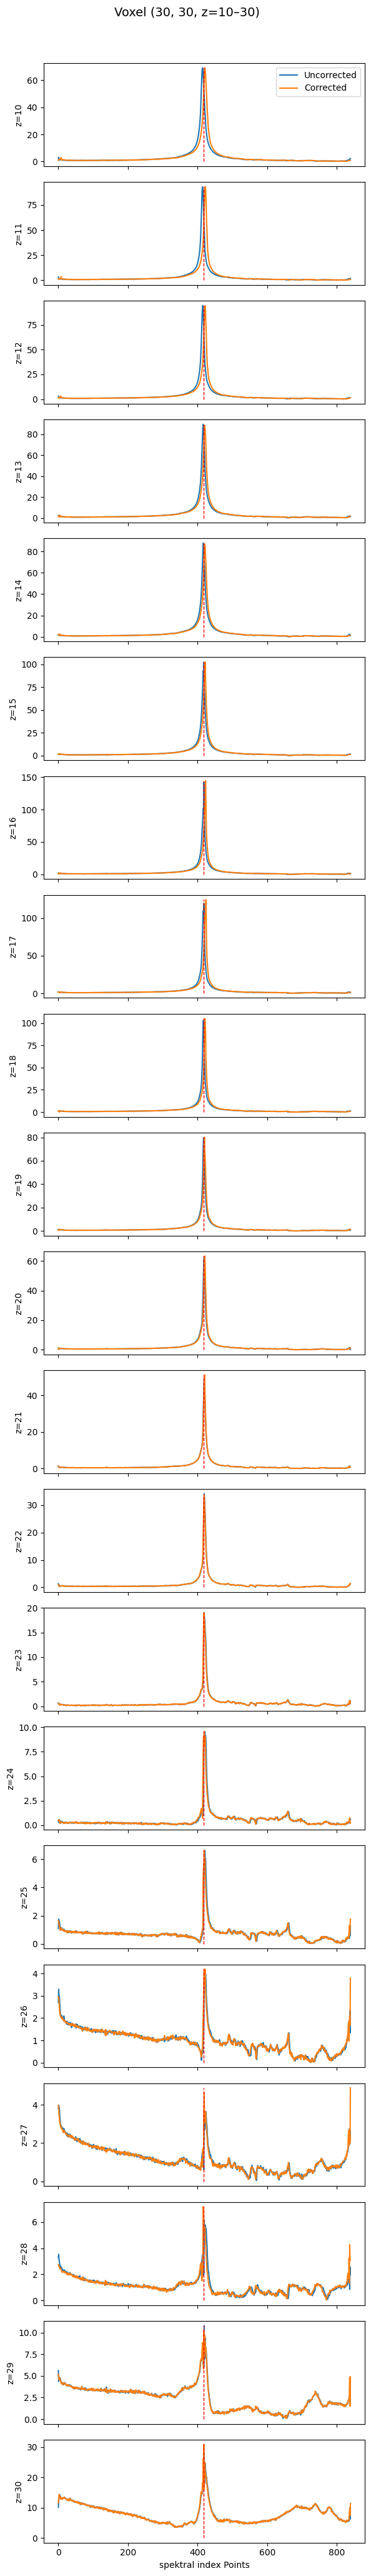

In [14]:
import matplotlib.pyplot as plt
import numpy as np

x, y = 30, 30
z_range = range(10, 31)

peak_index = 418

fig, axes = plt.subplots(len(z_range), 1, figsize=(6, len(z_range) * 2), sharex=True)

for i, z in enumerate(z_range):
    Line_1 = np.abs(uncorrected_ft)[x, y, z, :]
    Line_2 = np.abs(corrected_ft)[x, y, z, :]

    ax = axes[i]
    ax.plot(Line_1, label='Uncorrected')
    ax.plot(Line_2, label='Corrected')

    max_height = max(Line_1.max(), Line_2.max())
    ax.vlines(peak_index, ymin=0, ymax=max_height, color='red', linestyle='--', linewidth=1)

    ax.set_ylabel(f'z={z}')
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('spektral index Points')
fig.suptitle(f'Voxel ({x}, {y}, z=10–30)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Visualize B0 field

In [17]:
B_field = np.load(f'{Vol}/B0_estimation.npy')[...,0]
B_field = np.swapaxes(B_field, 0, 1)*mask

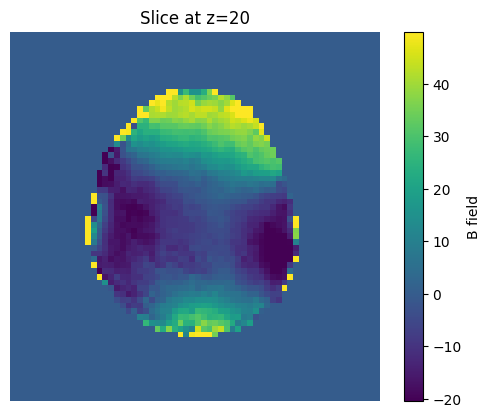

In [19]:
import numpy as np
import matplotlib.pyplot as plt

z = 20
Slice = B_field[..., z]

# Clip values to the 1st–99th percentile range for better contrast
vmin, vmax = np.percentile(Slice, [1, 99])

plt.figure()
im = plt.imshow(Slice, vmin=vmin, vmax=vmax, cmap='viridis')  # or any colormap you like
plt.colorbar(im, label='B field')
plt.title(f'Slice at z={z}')
plt.axis('off')  # optional: hide axis ticks
plt.show()
